In [2]:
import glob
import os

import pyforest
from my_module import *

pd.set_option("display.max_columns", 200)
pd.set_option("display.float_format", lambda x: "%.2f" % x)
# pd.set_option('display.max_colwidth', 50)

import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
df1 = pd.read_csv("Data/olist_customers_dataset.csv")
df1.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [5]:
# Several city spelling (special characters)
df1["customer_city"] = (
    df1["customer_city"]
    .str.normalize("NFKD")
    .str.encode("ascii", errors="ignore")
    .str.decode("utf-8")
)

In [6]:
df2 = pd.read_csv("Data/olist_geolocation_dataset.csv")
df2

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.55,-46.64,sao paulo,SP
1,1046,-23.55,-46.64,sao paulo,SP
2,1046,-23.55,-46.64,sao paulo,SP
3,1041,-23.54,-46.64,sao paulo,SP
4,1035,-23.54,-46.64,sao paulo,SP
...,...,...,...,...,...
1000158,99950,-28.07,-52.01,tapejara,RS
1000159,99900,-27.88,-52.22,getulio vargas,RS
1000160,99950,-28.07,-52.01,tapejara,RS
1000161,99980,-28.39,-51.85,david canabarro,RS


In [7]:
# Several lat. and long. for same zip code --> mean
df2 = df2.groupby(["geolocation_zip_code_prefix"]).mean().reset_index()
df2.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
0,1001,-23.55,-46.63
1,1002,-23.55,-46.63
2,1003,-23.55,-46.64
3,1004,-23.55,-46.63
4,1005,-23.55,-46.64


In [8]:
df = df1.merge(
    df2[["geolocation_zip_code_prefix", "geolocation_lat", "geolocation_lng"]],
    right_on="geolocation_zip_code_prefix",
    left_on="customer_zip_code_prefix",
    how="left",
)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   customer_id                  99441 non-null  object 
 1   customer_unique_id           99441 non-null  object 
 2   customer_zip_code_prefix     99441 non-null  int64  
 3   customer_city                99441 non-null  object 
 4   customer_state               99441 non-null  object 
 5   geolocation_zip_code_prefix  99163 non-null  float64
 6   geolocation_lat              99163 non-null  float64
 7   geolocation_lng              99163 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 6.8+ MB


In [9]:
df.nunique()

customer_id                    99441
customer_unique_id             96096
customer_zip_code_prefix       14994
customer_city                   4119
customer_state                    27
geolocation_zip_code_prefix    14837
geolocation_lat                14837
geolocation_lng                14837
dtype: int64

In [10]:
df3 = pd.read_csv("data/olist_orders_dataset.csv")
df3.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [11]:
df = df.merge(df3, on="customer_id")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer_id                    99441 non-null  object 
 1   customer_unique_id             99441 non-null  object 
 2   customer_zip_code_prefix       99441 non-null  int64  
 3   customer_city                  99441 non-null  object 
 4   customer_state                 99441 non-null  object 
 5   geolocation_zip_code_prefix    99163 non-null  float64
 6   geolocation_lat                99163 non-null  float64
 7   geolocation_lng                99163 non-null  float64
 8   order_id                       99441 non-null  object 
 9   order_status                   99441 non-null  object 
 10  order_purchase_timestamp       99441 non-null  object 
 11  order_approved_at              99281 non-null  object 
 12  order_delivered_carrier_date   97658 non-null 

In [12]:
df4 = pd.read_csv("Data/olist_order_reviews_dataset.csv")
df4.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [13]:
# Several reviews for the same order
df4.nunique()

review_id                  98410
order_id                   98673
review_score                   5
review_comment_title        4527
review_comment_message     36159
review_creation_date         636
review_answer_timestamp    98248
dtype: int64

In [14]:
# Keeping only the last review
df4 = df4.sort_values("review_creation_date").drop_duplicates(["order_id"], keep="last")
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98673 entries, 70906 to 17900
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                98673 non-null  object
 1   order_id                 98673 non-null  object
 2   review_score             98673 non-null  int64 
 3   review_comment_title     11552 non-null  object
 4   review_comment_message   40776 non-null  object
 5   review_creation_date     98673 non-null  object
 6   review_answer_timestamp  98673 non-null  object
dtypes: int64(1), object(6)
memory usage: 6.0+ MB


In [15]:
df.merge(df4, on="order_id", how="left").info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer_id                    99441 non-null  object 
 1   customer_unique_id             99441 non-null  object 
 2   customer_zip_code_prefix       99441 non-null  int64  
 3   customer_city                  99441 non-null  object 
 4   customer_state                 99441 non-null  object 
 5   geolocation_zip_code_prefix    99163 non-null  float64
 6   geolocation_lat                99163 non-null  float64
 7   geolocation_lng                99163 non-null  float64
 8   order_id                       99441 non-null  object 
 9   order_status                   99441 non-null  object 
 10  order_purchase_timestamp       99441 non-null  object 
 11  order_approved_at              99281 non-null  object 
 12  order_delivered_carrier_date   97658 non-null 

In [16]:
df5 = pd.read_csv("Data/olist_order_items_dataset.csv")
df5.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [17]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [18]:
df_temp = df.merge(df5, on="order_id", how="outer", indicator=True)
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113425 entries, 0 to 113424
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   customer_id                    113425 non-null  object  
 1   customer_unique_id             113425 non-null  object  
 2   customer_zip_code_prefix       113425 non-null  int64   
 3   customer_city                  113425 non-null  object  
 4   customer_state                 113425 non-null  object  
 5   geolocation_zip_code_prefix    113119 non-null  float64 
 6   geolocation_lat                113119 non-null  float64 
 7   geolocation_lng                113119 non-null  float64 
 8   order_id                       113425 non-null  object  
 9   order_status                   113425 non-null  object  
 10  order_purchase_timestamp       113425 non-null  object  
 11  order_approved_at              113264 non-null  object  
 12  order_delivered_

In [19]:
df_temp["_merge"].value_counts()

both          112650
left_only        775
right_only         0
Name: _merge, dtype: int64

In [20]:
df_temp[df_temp["_merge"] == "left_only"]

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,_merge
50,f34a6e874087ec1f0e3dab9fdf659c5d,233896de79986082f1f479f1f85281cb,38300,ituiutaba,MG,38300.00,-18.98,-49.46,6e98de3a85c84ead6689189b825d35b5,canceled,2018-03-15 10:07:02,2018-03-15 10:29:33,NaN,NaN,2018-04-09 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,left_only
330,5bfe800011656c0afb81db64519982db,0071f46a072a9ae25bbe4438b15efe9c,16011,aracatuba,SP,16011.00,-21.21,-50.42,df8c077268f7f3baaac0892eb3143642,unavailable,2017-02-01 00:04:17,2017-02-01 00:30:55,NaN,NaN,2017-03-10 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,left_only
422,b08064e24083fee8fbe8797902b07ecd,035f60af6e7d7f78470e9443be08d339,28495,aperibe,RJ,28495.00,-21.63,-42.10,c609f82bcf7a90292a5940205ebd7e93,unavailable,2018-05-13 16:45:55,2018-05-13 17:11:58,NaN,NaN,2018-06-05 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,left_only
432,536f46cc0f2f2b1e40d056f7998f0254,340152332a04149987a705602615f0d0,87030,maringa,PR,87030.00,-23.41,-51.93,cb4a79c1e6c9ae44302861e7602cc449,unavailable,2017-12-06 15:46:07,2017-12-06 15:57:29,NaN,NaN,2018-01-03 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,left_only
627,8118922685d2e2c0205f060be4f2579c,d0e87d00021530383c16452a39a393ba,45810,porto seguro,BA,45810.00,-16.43,-39.08,af264f3527e94e431f0dcd56cd6b406d,unavailable,2017-07-12 14:49:11,2017-07-12 15:04:10,NaN,NaN,2017-08-11 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112085,7353b0fb8e8d9675e3a704c60ca44ebe,21c933c8dd97d088e64c50988c90ccf5,5017,sao paulo,SP,5017.00,-23.54,-46.68,2f634e2cebf8c0283e7ef0989f77d217,unavailable,2017-09-27 20:55:33,2017-09-28 01:32:50,NaN,NaN,2017-10-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,left_only
112143,5effe9491d0f5a1c12ee4a384ec09bdf,e9429d622d9e764ca60ba01bc252b0a8,8690,suzano,SP,8690.00,-23.50,-46.32,2b0edc4c59d83dcef85466718c36a317,unavailable,2017-09-29 19:17:10,2017-09-29 20:00:07,NaN,NaN,2017-10-17 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,left_only
112412,75c6e03e7206bd1dd59f427c9f75142a,ff36be26206fffe1eb37afd54c70e18b,13057,campinas,SP,13057.00,-22.97,-47.16,81b7c7bbc8ec003eeb67d87441a6a148,canceled,2018-08-20 09:03:23,NaN,NaN,NaN,2018-09-03 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,left_only
112517,1761db2f0d235bbfa1c281093198af0c,21c2c79d24e2d8e3496aabb1f65d85c6,20270,rio de janeiro,RJ,20270.00,-22.92,-43.22,8b08f0e729f58529ed03e763270f78d5,unavailable,2017-08-24 21:02:47,2017-08-24 21:15:36,NaN,NaN,2017-09-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [21]:
# Order_id without order_item_id, price... --> drop
df = df.merge(df5, on="order_id", how="inner", indicator=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   customer_id                    112650 non-null  object  
 1   customer_unique_id             112650 non-null  object  
 2   customer_zip_code_prefix       112650 non-null  int64   
 3   customer_city                  112650 non-null  object  
 4   customer_state                 112650 non-null  object  
 5   geolocation_zip_code_prefix    112348 non-null  float64 
 6   geolocation_lat                112348 non-null  float64 
 7   geolocation_lng                112348 non-null  float64 
 8   order_id                       112650 non-null  object  
 9   order_status                   112650 non-null  object  
 10  order_purchase_timestamp       112650 non-null  object  
 11  order_approved_at              112635 non-null  object  
 12  order_delivered_

In [22]:
df6 = pd.read_csv("Data/olist_sellers_dataset.csv")
df6.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [23]:
df2.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
0,1001,-23.55,-46.63
1,1002,-23.55,-46.63
2,1003,-23.55,-46.64
3,1004,-23.55,-46.63
4,1005,-23.55,-46.64


In [24]:
# Seller latitude and longitude (calculate distance between seller and buyer)
df6_temp = df6.merge(
    df2, left_on="seller_zip_code_prefix", right_on="geolocation_zip_code_prefix"
).drop(columns=["geolocation_zip_code_prefix"])
df6_temp.rename(
    columns={
        "geolocation_lat": "seller_geolocation_lat",
        "geolocation_lng": "seller_geolocation_lng",
    },
    inplace=True,
)

In [25]:
df6_temp.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state,seller_geolocation_lat,seller_geolocation_lng
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,-22.89,-47.06
1,e0eabded302882513ced4ea3eb0c7059,13023,campinas,SP,-22.89,-47.06
2,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,-22.38,-46.95
3,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ,-22.91,-43.18
4,1d2732ef8321502ee8488e8bed1ab8cd,20031,rio de janeiro,RJ,-22.91,-43.18


In [26]:
df.merge(df6_temp, on="seller_id").info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112397 entries, 0 to 112396
Data columns (total 27 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   customer_id                    112397 non-null  object  
 1   customer_unique_id             112397 non-null  object  
 2   customer_zip_code_prefix       112397 non-null  int64   
 3   customer_city                  112397 non-null  object  
 4   customer_state                 112397 non-null  object  
 5   geolocation_zip_code_prefix    112096 non-null  float64 
 6   geolocation_lat                112096 non-null  float64 
 7   geolocation_lng                112096 non-null  float64 
 8   order_id                       112397 non-null  object  
 9   order_status                   112397 non-null  object  
 10  order_purchase_timestamp       112397 non-null  object  
 11  order_approved_at              112382 non-null  object  
 12  order_delivered_

In [27]:
# No seller --> Drop
df = df.merge(df6_temp, on="seller_id", how="inner")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112397 entries, 0 to 112396
Data columns (total 27 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   customer_id                    112397 non-null  object  
 1   customer_unique_id             112397 non-null  object  
 2   customer_zip_code_prefix       112397 non-null  int64   
 3   customer_city                  112397 non-null  object  
 4   customer_state                 112397 non-null  object  
 5   geolocation_zip_code_prefix    112096 non-null  float64 
 6   geolocation_lat                112096 non-null  float64 
 7   geolocation_lng                112096 non-null  float64 
 8   order_id                       112397 non-null  object  
 9   order_status                   112397 non-null  object  
 10  order_purchase_timestamp       112397 non-null  object  
 11  order_approved_at              112382 non-null  object  
 12  order_delivered_

# RFM

In [28]:
df["order_status"].value_counts()

delivered      109948
shipped          1185
canceled          541
processing        357
invoiced          356
unavailable         7
approved            3
Name: order_status, dtype: int64

In [42]:
df_quick = df[df["order_status"] == "delivered"]

In [43]:
df_quick.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109948 entries, 0 to 112396
Data columns (total 27 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   customer_id                    109948 non-null  object  
 1   customer_unique_id             109948 non-null  object  
 2   customer_zip_code_prefix       109948 non-null  int64   
 3   customer_city                  109948 non-null  object  
 4   customer_state                 109948 non-null  object  
 5   geolocation_zip_code_prefix    109661 non-null  float64 
 6   geolocation_lat                109661 non-null  float64 
 7   geolocation_lng                109661 non-null  float64 
 8   order_id                       109948 non-null  object  
 9   order_status                   109948 non-null  object  
 10  order_purchase_timestamp       109948 non-null  object  
 11  order_approved_at              109933 non-null  object  
 12  order_delivered_

In [44]:
col = ["customer_id", "customer_unique_id", "order_purchase_timestamp", "price"]
df_quick = df_quick[col]
df_quick.head()

,customer_id,customer_unique_id,order_purchase_timestamp,price
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,124.99
1,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,2018-05-19 16:07:45,139.94
2,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 16:06:38,149.94
3,4c06b42fbf7b97ab10779cda5549cd1c,07d190f123147d9e89d4b922543d7948,2018-07-08 09:59:19,199.98
4,8276de07ef25225d412b8462d73f8664,332cf4e83e16004ba7dca932ce82475b,2017-04-02 22:15:27,129.60


In [45]:
df_quick["order_purchase_timestamp"] = pd.to_datetime(
    df_quick["order_purchase_timestamp"]
)
df_quick["date"] = df_quick["order_purchase_timestamp"].dt.date
del df_quick["order_purchase_timestamp"]

In [46]:
df_quick.head()

,customer_id,customer_unique_id,price,date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,124.99,2017-05-16
1,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,139.94,2018-05-19
2,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,149.94,2018-03-13
3,4c06b42fbf7b97ab10779cda5549cd1c,07d190f123147d9e89d4b922543d7948,199.98,2018-07-08
4,8276de07ef25225d412b8462d73f8664,332cf4e83e16004ba7dca932ce82475b,129.60,2017-04-02


In [40]:
from datetime import timedelta

# Create snapshot date
snapshot_date = df_quick["date"].max() + timedelta(days=1)
print(snapshot_date)

2018-08-30


In [83]:
# Grouping by CustomerID
data_process = df_quick.groupby(["customer_unique_id"]).agg(
    {
        "date": lambda x: (snapshot_date - x.max()).days,
        "customer_id": "count",
        "price": "sum",
    }
)

# Rename the columns
data_process.rename(
    columns={"date": "Recency", "customer_id": "Frequency", "price": "MonetaryValue"},
    inplace=True,
)

In [84]:
data_process.describe()

,Recency,Frequency,MonetaryValue
count,93158.00,93158.00,93158.00
mean,238.44,1.18,141.65
std,152.62,0.62,215.86
min,1.00,1.00,0.85
25%,115.00,1.00,47.65
50%,219.00,1.00,89.59
75%,347.00,1.00,154.90
max,714.00,24.00,13440.00


In [85]:
data_process.head()

,Recency,Frequency,MonetaryValue
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90
0000f46a3911fa3c0805444483337064,538,1,69.00
0000f6ccb0745a6a4b88665a16c9f078,322,1,25.99
0004aac84e0df4da2b147fca70cf8255,289,1,180.00


In [86]:
data_process.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93158 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Recency        93158 non-null  int64  
 1   Frequency      93158 non-null  int64  
 2   MonetaryValue  93158 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.8+ MB


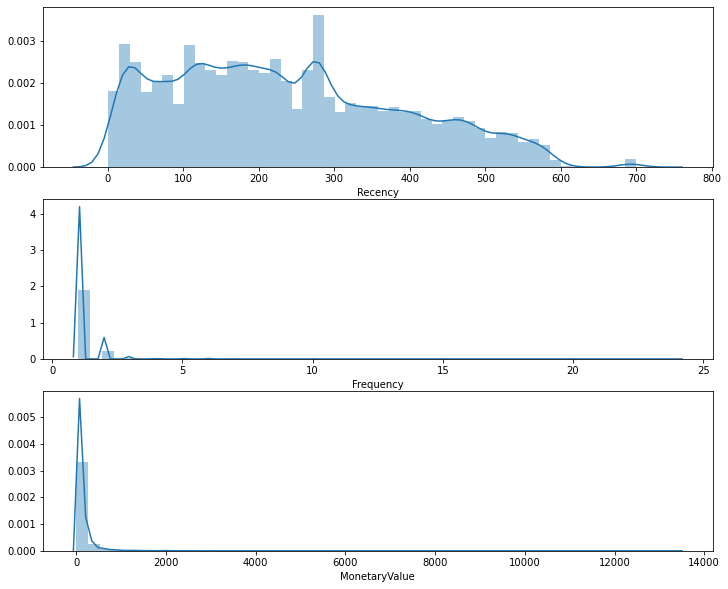

In [87]:
# Plot RFM distributions
plt.figure(figsize=(12, 10))
# Plot distribution of R
plt.subplot(3, 1, 1)
sns.distplot(data_process["Recency"])
# Plot distribution of F
plt.subplot(3, 1, 2)
sns.distplot(data_process["Frequency"])
# Plot distribution of M
plt.subplot(3, 1, 3)
sns.distplot(data_process["MonetaryValue"])
# Show the plot
plt.show()

This plot provides us with some very interesting insights and how skewed our data is. The important thing to take note here is that we will be grouping these values in quantiles. However, when we examine our customer segmentation using K-Means in the next, it will be very important to ensure that we scale our data to center the mean and standard deviations. More on that next time. Let us proceed with the .qcut() for our RFM.

In [96]:
# --Calculate R and F groups--
# Create labels for Recency and Frequency
r_labels = range(4, 0, -1)
m_labels = range(1, 5)

# Assign these labels to 4 equal percentile groups
r_groups = pd.qcut(data_process["Recency"], q=4, labels=r_labels)
m_groups = pd.qcut(data_process["MonetaryValue"], q=4, labels=m_labels)

# Assign manually frequency to 1, 2, 3 and more purchases (lots of frequency 1)
data_process["F"] = data_process["Frequency"]
data_process.loc[data_process["F"] > 3, "F"] = 4

# Create new columns R and F
data_process = data_process.assign(R=r_groups.values, M=m_groups.values)
data_process.head()

,Recency,Frequency,MonetaryValue,F,R,M,RFM_Segment,RFM_Score
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,1,4,3,413,0.00
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,1,4,1,411,0.00
0000f46a3911fa3c0805444483337064,538,1,69.00,1,1,2,112,0.00
0000f6ccb0745a6a4b88665a16c9f078,322,1,25.99,1,2,1,211,0.00
0004aac84e0df4da2b147fca70cf8255,289,1,180.00,1,2,4,214,0.00


In [101]:
data_process.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93158 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Recency        93158 non-null  int64  
 1   Frequency      93158 non-null  int64  
 2   MonetaryValue  93158 non-null  float64
 3   F              93158 non-null  int64  
 4   R              93158 non-null  int32  
 5   M              93158 non-null  int32  
 6   RFM_Segment    93158 non-null  object 
 7   RFM_Score      93158 non-null  float64
dtypes: float64(2), int32(2), int64(3), object(1)
memory usage: 5.7+ MB


In [100]:
col = ["R", "M"]
data_process[col] = data_process[col].astype(int)

In [103]:
def join_rfm(x):
    return str(x["R"]) + str(x["F"]) + str(x["M"])


data_process["RFM_Segment"] = data_process.apply(join_rfm, axis=1)
rfm = data_process
rfm.head()

,Recency,Frequency,MonetaryValue,F,R,M,RFM_Segment,RFM_Score
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,1,4,3,413,0.00
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,1,4,1,411,0.00
0000f46a3911fa3c0805444483337064,538,1,69.00,1,1,2,112,0.00
0000f6ccb0745a6a4b88665a16c9f078,322,1,25.99,1,2,1,211,0.00
0004aac84e0df4da2b147fca70cf8255,289,1,180.00,1,2,4,214,0.00


In [104]:
# Count num of unique segments
data_process["RFM_Segment"].nunique()

64

In [106]:
rfm["RFM_Score"] = rfm[["R", "F", "M"]].sum(axis=1)
rfm.head()

,Recency,Frequency,MonetaryValue,F,R,M,RFM_Segment,RFM_Score
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,1,4,3,413,8
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,1,4,1,411,6
0000f46a3911fa3c0805444483337064,538,1,69.00,1,1,2,112,4
0000f6ccb0745a6a4b88665a16c9f078,322,1,25.99,1,2,1,211,4
0004aac84e0df4da2b147fca70cf8255,289,1,180.00,1,2,4,214,7


In [107]:
# Define rfm_level function
def rfm_level(df):
    if df["RFM_Score"] >= 9:
        return "Can't Loose Them"
    elif (df["RFM_Score"] >= 8) and (df["RFM_Score"] < 9):
        return "Champions"
    elif (df["RFM_Score"] >= 7) and (df["RFM_Score"] < 8):
        return "Loyal"
    elif (df["RFM_Score"] >= 6) and (df["RFM_Score"] < 7):
        return "Potential"
    elif (df["RFM_Score"] >= 5) and (df["RFM_Score"] < 6):
        return "Promising"
    elif (df["RFM_Score"] >= 4) and (df["RFM_Score"] < 5):
        return "Needs Attention"
    else:
        return "Require Activation"


# Create a new variable RFM_Level
rfm["RFM_Level"] = rfm.apply(rfm_level, axis=1)
# Print the header with top 5 rows to the console
rfm.head()

,Recency,Frequency,MonetaryValue,F,R,M,RFM_Segment,RFM_Score,RFM_Level
customer_unique_id,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,1,4,3,413,8,Champions
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,1,4,1,411,6,Potential
0000f46a3911fa3c0805444483337064,538,1,69.00,1,1,2,112,4,Needs Attention
0000f6ccb0745a6a4b88665a16c9f078,322,1,25.99,1,2,1,211,4,Needs Attention
0004aac84e0df4da2b147fca70cf8255,289,1,180.00,1,2,4,214,7,Loyal


In [108]:
# Calculate average values for each RFM_Level, and return a size of each segment
rfm_level_agg = (
    rfm.groupby("RFM_Level")
    .agg({"Recency": "mean", "Frequency": "mean", "MonetaryValue": ["mean", "count"]})
    .round(1)
)
# Print the aggregated dataset
print(rfm_level_agg)

                   Recency Frequency MonetaryValue       
                      mean      mean          mean  count
RFM_Level                                                
Can't Loose Them     98.20      2.00        337.60   8974
Champions           131.80      1.30        219.70  12073
Loyal               181.30      1.10        167.70  17097
Needs Attention     363.60      1.00         46.30  10999
Potential           234.90      1.10        131.70  21618
Promising           297.80      1.00         67.30  16715
Require Activation  455.30      1.00         28.70   5682


Potential — high potential to enter our loyal customer segments, why not throw in some freebies on their next purchase to show that you value them!  
Promising — showing promising signs with quantity and value of their purchase but it has been a while since they last bought sometime from you. Let’s target them with their wishlist items and a limited time offer discount.  
Needs Attention — made some initial purchase but have not seen them since. Was it a bad customer experience? Or product-market fit? Let’s spend some resource build our brand awareness with them.  
Require Activation — Poorest performers of our RFM model. They might have went with our competitors for now and will require a different activation strategy to win them back.  

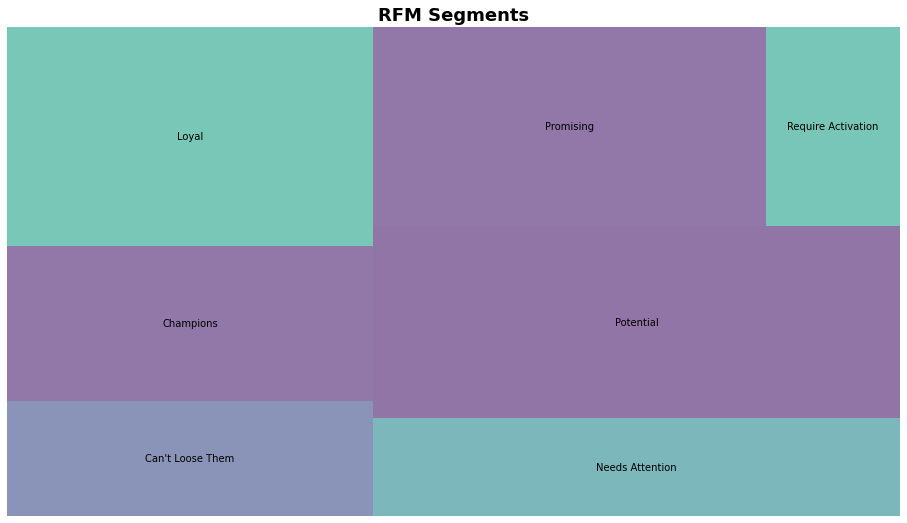

In [113]:
import squarify

rfm_level_agg.columns = ["RecencyMean", "FrequencyMean", "MonetaryMean", "Count"]
# Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(
    sizes=rfm_level_agg["Count"],
    label=[
        "Can't Loose Them",
        "Champions",
        "Loyal",
        "Needs Attention",
        "Potential",
        "Promising",
        "Require Activation",
    ],
    alpha=0.6,
)
plt.title("RFM Segments", fontsize=18, fontweight="bold")
plt.axis("off")
plt.show()